In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
rdd=sc.textFile("C:/Users/Abhishek/Downloads/credit_card.csv")

In [3]:
rdd.take(5)

['step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud',
 '1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0',
 '1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0',
 '1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0',
 '1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0']

In [4]:
header=rdd.first()
header

'step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud'

In [5]:
headers=header.split(",")
print(headers)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [6]:
#Removing the header from the RDD

rdd=rdd.filter(lambda line:line!=header)
rdd.take(2)

['1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0',
 '1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0']

In [7]:
rdd=rdd.map(lambda line: line.split(","))
rdd.take(2)

[['1',
  'PAYMENT',
  '9839.64',
  'C1231006815',
  '170136.0',
  '160296.36',
  'M1979787155',
  '0.0',
  '0.0',
  '0',
  '0'],
 ['1',
  'PAYMENT',
  '1864.28',
  'C1666544295',
  '21249.0',
  '19384.72',
  'M2044282225',
  '0.0',
  '0.0',
  '0',
  '0']]

In [8]:
#Converting RDD to Spark Dataframe

from pyspark.sql import Row

df=rdd.map(lambda line:Row(step=line[0],
                        Type=line[1],
                        amount=line[2],
                        nameOrig=line[3],
                        oldbalanceOrg=line[4],
                        newbalanceOrig=line[5],
                        nameDest=line[6],
                        oldbalanceDest=line[7],
                        newbalanceDest=line[8],
                        isFraud=line[9],
                        isFlaggedFraud=line[10])).toDF()

In [9]:
df.show(10)

+--------+--------+--------------+-------+-----------+-----------+--------------+--------------+--------------+-------------+----+
|    Type|  amount|isFlaggedFraud|isFraud|   nameDest|   nameOrig|newbalanceDest|newbalanceOrig|oldbalanceDest|oldbalanceOrg|step|
+--------+--------+--------------+-------+-----------+-----------+--------------+--------------+--------------+-------------+----+
| PAYMENT| 9839.64|             0|      0|M1979787155|C1231006815|           0.0|     160296.36|           0.0|     170136.0|   1|
| PAYMENT| 1864.28|             0|      0|M2044282225|C1666544295|           0.0|      19384.72|           0.0|      21249.0|   1|
|TRANSFER|   181.0|             0|      1| C553264065|C1305486145|           0.0|           0.0|           0.0|        181.0|   1|
|CASH_OUT|   181.0|             0|      1|  C38997010| C840083671|           0.0|           0.0|       21182.0|        181.0|   1|
| PAYMENT|11668.14|             0|      0|M1230701703|C2048537720|           0.0|  

In [10]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- step: string (nullable = true)



In [11]:
#Note that all columns are of string type. So we need to change those to proper types

In [12]:
#Converting "type" to integer category

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="Type", outputCol="Type_t")
indexed = indexer.fit(df).transform(df)

In [13]:
#Changing the columns to proper types

from pyspark.sql.types import *
def changeType(columnName,t): #t=type
    global indexed
    indexed=indexed.withColumn(columnName,indexed[columnName].cast(t()))

changeType("amount",FloatType)
changeType("newbalanceDest",FloatType)
changeType("newbalanceOrig",FloatType)
changeType("oldbalanceDest",FloatType)
changeType("oldbalanceOrg",FloatType)
changeType("isFlaggedFraud",IntegerType)
changeType("isFraud",IntegerType)
changeType("step",IntegerType)

In [14]:
indexed.show()

+--------+---------+--------------+-------+-----------+-----------+--------------+--------------+--------------+-------------+----+------+
|    Type|   amount|isFlaggedFraud|isFraud|   nameDest|   nameOrig|newbalanceDest|newbalanceOrig|oldbalanceDest|oldbalanceOrg|step|Type_t|
+--------+---------+--------------+-------+-----------+-----------+--------------+--------------+--------------+-------------+----+------+
| PAYMENT|  9839.64|             0|      0|M1979787155|C1231006815|           0.0|     160296.36|           0.0|     170136.0|   1|   1.0|
| PAYMENT|  1864.28|             0|      0|M2044282225|C1666544295|           0.0|      19384.72|           0.0|      21249.0|   1|   1.0|
|TRANSFER|    181.0|             0|      1| C553264065|C1305486145|           0.0|           0.0|           0.0|        181.0|   1|   3.0|
|CASH_OUT|    181.0|             0|      1|  C38997010| C840083671|           0.0|           0.0|       21182.0|        181.0|   1|   0.0|
| PAYMENT| 11668.14|       

In [15]:
# Enable Arrow-based columnar data transfers

spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [16]:
# Convert the Spark DataFrame back to a Pandas DataFrame using Arrow
#This could be used for plotting graphs using plotnine's ggplot

result_pdf = indexed.select("*").toPandas()

In [17]:
from pyspark.sql import *
sqlContext = SQLContext(sc)
indexed.createOrReplaceTempView("table")

In [18]:
#Count the number of cases under fraud and not fraud categories
#1 is for fraud and 0 means not fraud

query="SELECT ISFRAUD,COUNT(ISFRAUD) AS COUNTS FROM TABLE GROUP BY ISFRAUD"
result=spark.sql(query)

In [19]:
result.show()

+-------+-------+
|ISFRAUD| COUNTS|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



In [20]:
from plotnine import *
%matplotlib inline

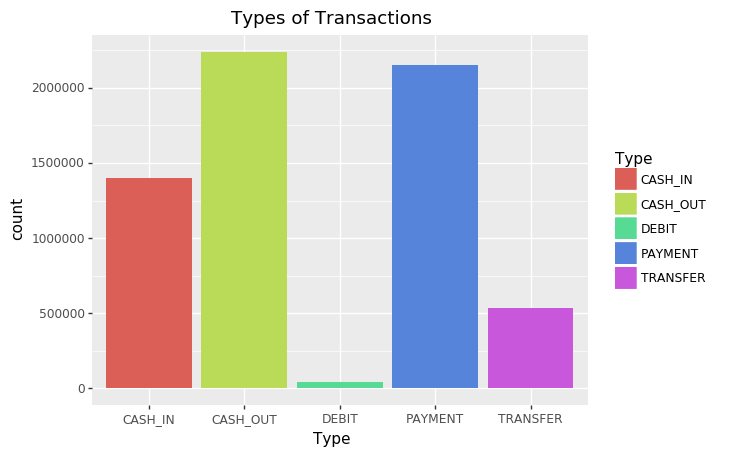

<ggplot: (122891731085)>

In [21]:
#Plots the number of transactions under various categories

(ggplot(result_pdf)                      # defining what data to use
 + aes(x='Type',fill='Type')             # defining what variable to use
 + geom_bar()                            # defining the type of plot to use
 + labs(title='Types of Transactions'))

In [22]:
#We observe that most transactions are either CashOut or Payment and Debits are the least

In [23]:
#Only the fraud transactions as a subset of the table

query="SELECT * FROM TABLE WHERE ISFRAUD=1"
result=spark.sql(query)
result_df=result.toPandas()

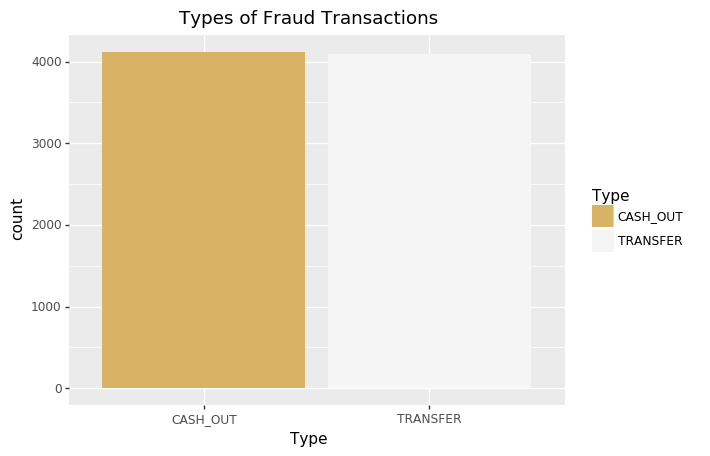

<ggplot: (122892049451)>

In [24]:
#Plots the number of fraud transactions under various categories

(ggplot(result_df)
+aes(x='Type',fill='Type')
+geom_bar(size=15)
+labs(title='Types of Fraud Transactions')
+scale_fill_brewer(type='div'))

In [25]:
#We observe that fraud transactions are only under the categories of CashOut and Transfer
#It may be that the money is first transferred to the fraud account and then its cashed out

In [26]:
#Now preparing the data for machine learning

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Type_t","amount","newbalanceDest","newbalanceOrig","oldbalanceDest","oldbalanceOrg","step"],
    outputCol="features")

In [27]:
output = assembler.transform(indexed)

In [28]:
output = output.select("features","isFraud")

In [29]:
output=output.withColumnRenamed("isFraud", "label")

In [30]:
output.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,9839.6396484...|    0|
|[1.0,1864.2800292...|    0|
|[3.0,181.0,0.0,0....|    1|
|[0.0,181.0,0.0,0....|    1|
|[1.0,11668.139648...|    0|
+--------------------+-----+
only showing top 5 rows



In [31]:
output.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [32]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = output.randomSplit([0.7, 0.3])

In [33]:
#Trying the Logistic Regression Classification model

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

# Fit the model
lrModel = lr.fit(trainingData)

predictions=lrModel.transform(testData)

In [34]:
temp=predictions.select("label","prediction")

In [35]:
tp = temp[(temp.label == 1) & (temp.prediction == 1)].count() #true positive
tn = temp[(temp.label == 0) & (temp.prediction == 0)].count() #true negative
fp = temp[(temp.label == 0) & (temp.prediction == 1)].count() #false positive
fn = temp[(temp.label == 1) & (temp.prediction == 0)].count() #false negative

In [36]:
#Let's say for your business the goal is to avoid fraud at all costs, 
#then one would strive to achieve as high recall values as possible. 
#But if it matters to you that you don't predict non-fraud cases as fraud, 
#maybe because it hurts customer-sentiment, precision is more important.

In [39]:
#As we are just doing this to get accustomed to using Spark for Machine Learning and we wish to seek a balance between both 
#precision and recall, we can consider taking a look at the F1 score which is just a weighted average of both.

In [40]:
precision=tp/(tp+fp)

recall=tp/(tp+fn)

f1=2*precision*recall/(precision+recall)

print("F1 Score = ",f1)

F1 Score =  0.21641791044776118


In [41]:
#Trying the random forest classification model

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=5)

model=rf.fit(trainingData)

predictions=model.transform(testData)

In [42]:
#Saving the model

model.save("randomForest.model")

In [43]:
#Just trying out the method to use a saved model

from pyspark.ml.classification import RandomForestClassificationModel
sameModel = RandomForestClassificationModel.load("randomForest.model")

In [44]:
predictions=sameModel.transform(testData)
temp=predictions.select("label","prediction")

In [45]:
tp = temp[(temp.label == 1) & (temp.prediction == 1)].count() #true positive
tn = temp[(temp.label == 0) & (temp.prediction == 0)].count() #true negative
fp = temp[(temp.label == 0) & (temp.prediction == 1)].count() #false positive
fn = temp[(temp.label == 1) & (temp.prediction == 0)].count() #false negative

In [46]:
precision=tp/(tp+fp)

recall=tp/(tp+fn)

f1=2*precision*recall/(precision+recall)

print("F1 Score = ",f1)

F1 Score =  0.6486793524566884


In [47]:
#We may consider using the Random Forest classification model above as of now (till I work on a better model).